100%|██████████| 2948/2948 [00:40<00:00, 72.87it/s] 


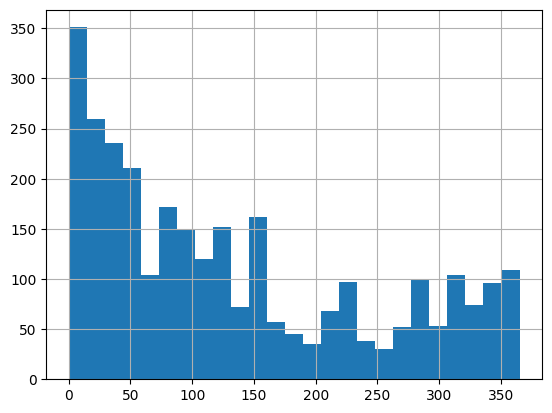

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, MandrillTripleImageDataset, MandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
hist = data["age"].hist(bins=25)

dataset = MandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, max_days=max_days)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm

from mandrill.models import InceptionResnetV1, RegressionModel, VGGFace
from mandrill.utils import split_dataset, load, save

learning_rate = 1e-4
batch_size = 64
num_epochs = 100
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)

# Model
# backbone = InceptionResnetV1()
backbone = VGGFace()
model = RegressionModel(backbone, input_dim=backbone.output_dim, lin_start=2048, n_lin=6)

# Loss function
criterion = nn.MSELoss()
val_criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = val_criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    
    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val L1: {val_loss:.4f}")

Using device: cuda


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [1/100] - Train Loss: 0.0581 - Val L1: 0.1728


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [2/100] - Train Loss: 0.0217 - Val L1: 0.0981


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch [3/100] - Train Loss: 0.0169 - Val L1: 0.0852


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch [4/100] - Train Loss: 0.0131 - Val L1: 0.0861


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Epoch [5/100] - Train Loss: 0.0110 - Val L1: 0.0849


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Epoch [6/100] - Train Loss: 0.0097 - Val L1: 0.0818


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch [7/100] - Train Loss: 0.0086 - Val L1: 0.0783


100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Epoch [8/100] - Train Loss: 0.0079 - Val L1: 0.0744


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Epoch [9/100] - Train Loss: 0.0077 - Val L1: 0.0690


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Epoch [10/100] - Train Loss: 0.0078 - Val L1: 0.0815


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch [11/100] - Train Loss: 0.0074 - Val L1: 0.0760


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [12/100] - Train Loss: 0.0066 - Val L1: 0.0770


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Epoch [13/100] - Train Loss: 0.0060 - Val L1: 0.0687


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch [14/100] - Train Loss: 0.0074 - Val L1: 0.0684


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch [15/100] - Train Loss: 0.0063 - Val L1: 0.0645


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [16/100] - Train Loss: 0.0052 - Val L1: 0.0631


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [17/100] - Train Loss: 0.0042 - Val L1: 0.0603


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [18/100] - Train Loss: 0.0050 - Val L1: 0.0688


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Epoch [19/100] - Train Loss: 0.0042 - Val L1: 0.0676


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Epoch [20/100] - Train Loss: 0.0053 - Val L1: 0.0714


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [21/100] - Train Loss: 0.0053 - Val L1: 0.0800


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Epoch [22/100] - Train Loss: 0.0057 - Val L1: 0.0707


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [23/100] - Train Loss: 0.0040 - Val L1: 0.0606


100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Epoch [24/100] - Train Loss: 0.0034 - Val L1: 0.0658


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [25/100] - Train Loss: 0.0031 - Val L1: 0.0564


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [26/100] - Train Loss: 0.0024 - Val L1: 0.0532


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch [27/100] - Train Loss: 0.0021 - Val L1: 0.0528


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [28/100] - Train Loss: 0.0022 - Val L1: 0.0503


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch [29/100] - Train Loss: 0.0016 - Val L1: 0.0529


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [30/100] - Train Loss: 0.0016 - Val L1: 0.0500


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch [31/100] - Train Loss: 0.0016 - Val L1: 0.0517


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [32/100] - Train Loss: 0.0015 - Val L1: 0.0573


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [33/100] - Train Loss: 0.0016 - Val L1: 0.0523


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [34/100] - Train Loss: 0.0017 - Val L1: 0.0532


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch [35/100] - Train Loss: 0.0015 - Val L1: 0.0508


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [36/100] - Train Loss: 0.0015 - Val L1: 0.0532


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [37/100] - Train Loss: 0.0026 - Val L1: 0.0588


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [38/100] - Train Loss: 0.0027 - Val L1: 0.0535


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch [39/100] - Train Loss: 0.0024 - Val L1: 0.0527


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [40/100] - Train Loss: 0.0024 - Val L1: 0.0541


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch [41/100] - Train Loss: 0.0038 - Val L1: 0.0837


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [42/100] - Train Loss: 0.0117 - Val L1: 0.0987


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [43/100] - Train Loss: 0.0082 - Val L1: 0.0713


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [44/100] - Train Loss: 0.0049 - Val L1: 0.0613


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch [45/100] - Train Loss: 0.0041 - Val L1: 0.0575


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [46/100] - Train Loss: 0.0031 - Val L1: 0.0603


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch [47/100] - Train Loss: 0.0029 - Val L1: 0.0557


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch [48/100] - Train Loss: 0.0045 - Val L1: 0.0736


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch [49/100] - Train Loss: 0.0056 - Val L1: 0.0669


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch [50/100] - Train Loss: 0.0034 - Val L1: 0.0618


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch [51/100] - Train Loss: 0.0029 - Val L1: 0.0556


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Epoch [52/100] - Train Loss: 0.0023 - Val L1: 0.0557


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [53/100] - Train Loss: 0.0018 - Val L1: 0.0576


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [54/100] - Train Loss: 0.0018 - Val L1: 0.0530


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Epoch [55/100] - Train Loss: 0.0040 - Val L1: 0.0730


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [56/100] - Train Loss: 0.0040 - Val L1: 0.0578


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [57/100] - Train Loss: 0.0032 - Val L1: 0.0633


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch [58/100] - Train Loss: 0.0025 - Val L1: 0.0580


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Epoch [59/100] - Train Loss: 0.0022 - Val L1: 0.0526


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [60/100] - Train Loss: 0.0028 - Val L1: 0.0539


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [61/100] - Train Loss: 0.0021 - Val L1: 0.0549


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Epoch [62/100] - Train Loss: 0.0016 - Val L1: 0.0493


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch [63/100] - Train Loss: 0.0014 - Val L1: 0.0535


100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Epoch [64/100] - Train Loss: 0.0013 - Val L1: 0.0494


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [65/100] - Train Loss: 0.0012 - Val L1: 0.0514


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch [66/100] - Train Loss: 0.0015 - Val L1: 0.0510


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch [67/100] - Train Loss: 0.0013 - Val L1: 0.0489


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch [68/100] - Train Loss: 0.0011 - Val L1: 0.0480


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch [69/100] - Train Loss: 0.0011 - Val L1: 0.0516


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch [70/100] - Train Loss: 0.0009 - Val L1: 0.0501


 11%|█         | 4/37 [00:07<01:00,  1.84s/it]


KeyboardInterrupt: 

Predicted Values: 34.74028840661049
Actual Values: 49.99999962747097
Prediction Error:  -15.259711220860481



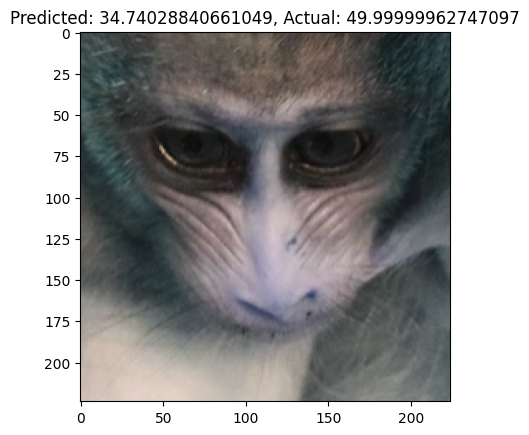

Predicted Values: 333.0547419190407
Actual Values: 344.99998927116394
Prediction Error:  -11.94524735212326



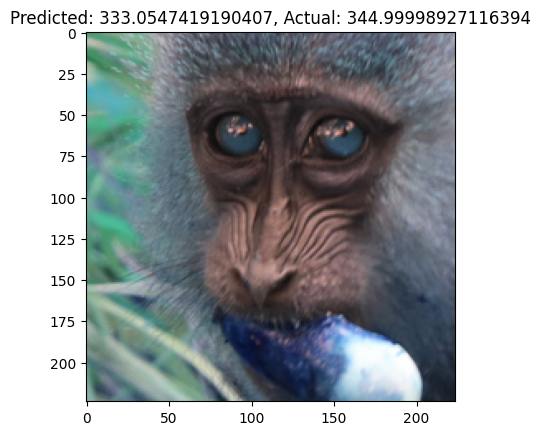

Predicted Values: 259.89599496126175
Actual Values: 164.00000095367432
Prediction Error:  95.89599400758743



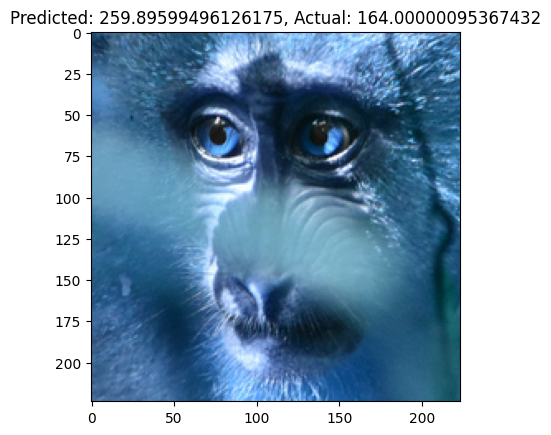

Predicted Values: 29.482597671449184
Actual Values: 39.999999701976776
Prediction Error:  -10.517402030527592



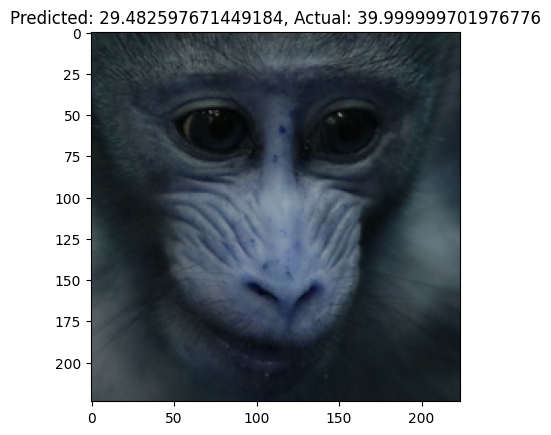

Predicted Values: 6.954485401511192
Actual Values: 10.999999782070518
Prediction Error:  -4.045514380559325



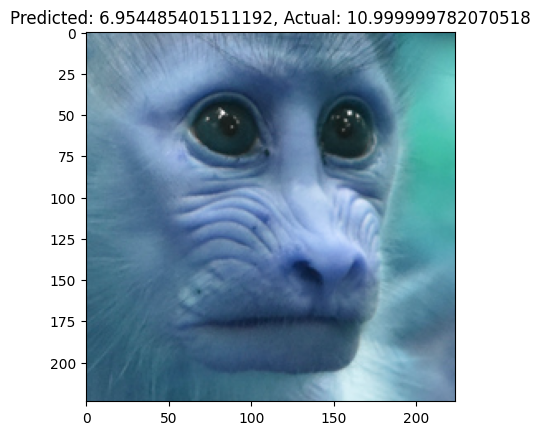

Predicted Values: 120.10786384344101
Actual Values: 111.00000515580177
Prediction Error:  9.107858687639236



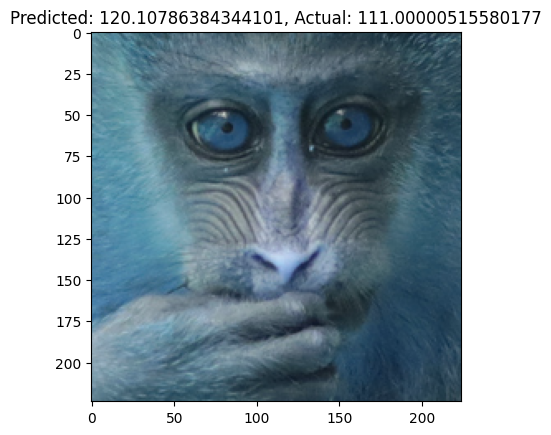

Predicted Values: 45.19040551036596
Actual Values: 53.00000123679638
Prediction Error:  -7.809595726430416



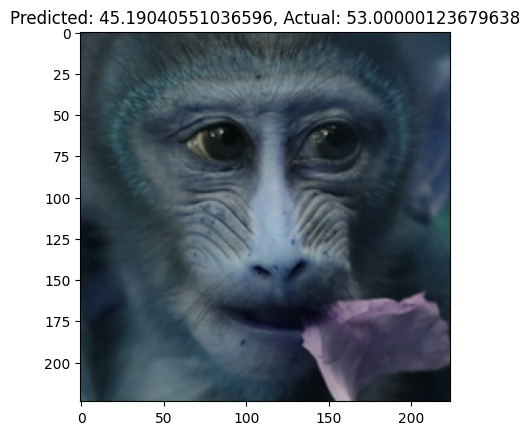

Predicted Values: 138.84939461946487
Actual Values: 182.99998939037323
Prediction Error:  -44.150594770908356



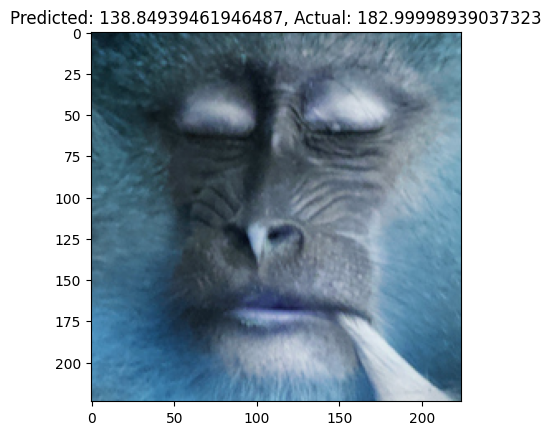

Predicted Values: 23.187603540718555
Actual Values: 8.000000212341547
Prediction Error:  15.187603328377008



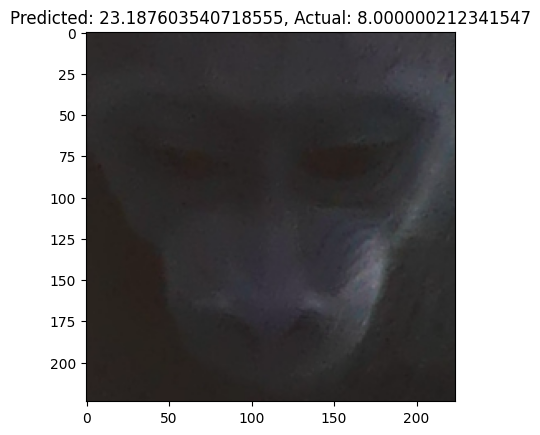

Predicted Values: 131.29551261663437
Actual Values: 98.99999871850014
Prediction Error:  32.29551389813423



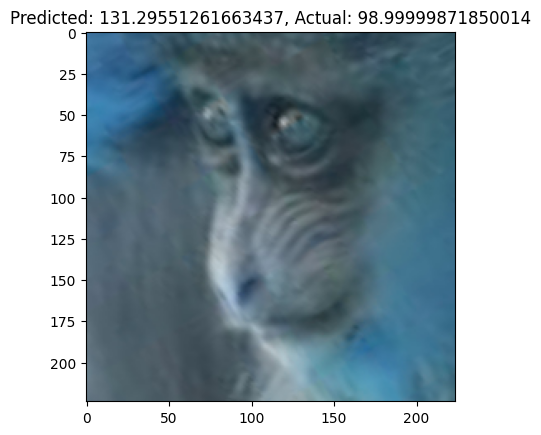

Absolute age error (in days):  0.2792942151960017  std:  32.0159724600201


In [4]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load

# model = load(model, "vgg_face", exp_name="exp1_regression")

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 10

age_errors = []
age_truth = []
age_predicted = []

model.eval()

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    predicted_values = outputs.squeeze().detach().cpu().numpy() * 365
    actual_values = targets.squeeze().cpu().numpy() * 365
    
    age_errors.append(predicted_values - actual_values)
    age_truth.append(actual_values)
    age_predicted.append(predicted_values)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", predicted_values)
    print("Actual Values:", actual_values)
    print("Prediction Error: ", predicted_values - actual_values)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

age_errors = np.array(age_errors)
print("Absolute age error (in days): ", np.mean(age_errors), " std: ", np.std(age_errors))

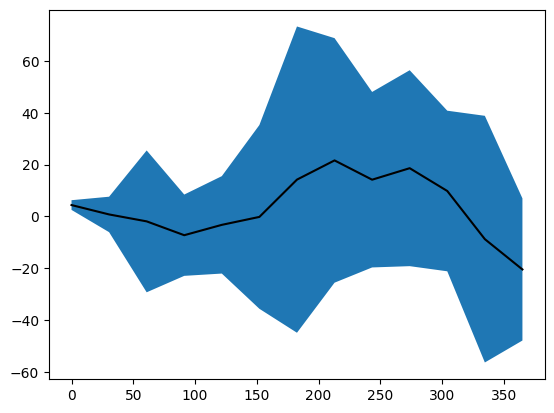

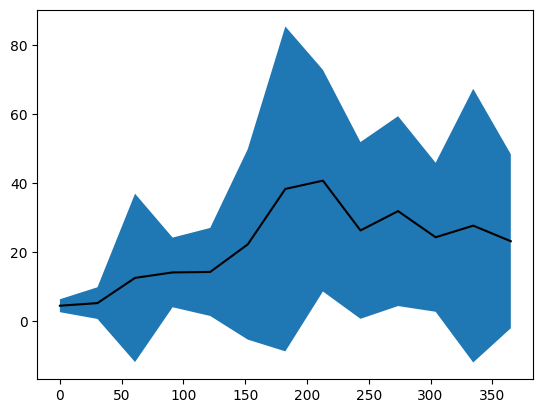

<Axes: >

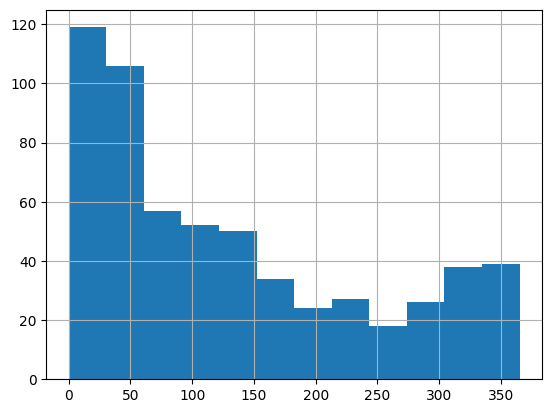

In [5]:
# Histogram with x being the real age and y being the error on this age
# Plotting the histogram

def group_by(x, n_bins):
    step = np.max(x) / n_bins
    x = np.array(x)
    for i in range(n_bins+1):
        nx = i*step
        px = max(0, (i-1)*step)
        x[np.logical_and(x <= nx, x > px)] = nx
    x[np.logical_and(x <= np.max(x), x > (n_bins*step))] = np.max(x)
    return x.tolist()

def bin_errors(x, y):
    bins = np.unique(x)
    y_mean = []
    y_err = []
    y = np.array(y)
    for b in bins:
        y_bin = y[x == b]
        y_mean.append(np.mean(y_bin))
        y_err.append(np.std(y_bin))
    return np.array(y_mean), np.array(y_err)

n_bins = 12

x = age_truth
y = age_errors

sorted_lists = sorted(zip(x, y))
sorted_x, sorted_y = zip(*sorted_lists)

def display_error_curve(x, y, n_bins):
    x = group_by(x, n_bins)
    y, y_err = bin_errors(x, y)
    x = np.unique(x)

    plt.plot(x, y, 'k-', label='Prediction error')
    plt.fill_between(x, y-y_err, y+y_err)
    plt.show()

display_error_curve(sorted_x, sorted_y, n_bins)
display_error_curve(sorted_x, abs(np.array(sorted_y)), n_bins)

# Age validation distribution
age_data = pd.DataFrame(data={"age": x})
age_data["age"].hist(bins=n_bins)

In [ ]:
#from mandrill.utils import save
#name="exp1_regression"
#save(model, "vgg_face", exp_name=name)
#print("saved")